In [1]:
import matplotlib.pylab as plt
import pandas as pd

In [32]:
# loop through the sheets of the spreadsheet; each sheet is a biological replicate
# of all 3 of the biolog plates. Columns are time in hours.
reps = {}
for i in range(0,4):
    biolog_raw = pd.read_excel('../data/experiments/biolog_raw.xlsx',sheet_name="rep_"+str(i+1))
    biolog_raw.columns = [col for col in biolog_raw.columns]
    reps[i] = biolog_raw
#print(reps)    
all_biolog = pd.concat([reps[0],reps[1],reps[2],reps[3]])
#print (all_biolog)
# convert to mean and std at each time point, 
# and get the max OD at all time points (from means)
##error in setting the index, previously only seting the index as a number, preventing them from flowing through the actual readout 
#all_biolog.set_index("Unnamed: 0", inplace = True)
mets = reps[0].index.unique()
print (mets)
means = {}
stds = {}
maxODs = {}
for met in mets:
    vals = pd.DataFrame()
    concat_axis = 1
    if met == 'Neg':
        concat_axis = 0
    
    for rep in reps:
        vals = pd.concat([vals,reps[rep].loc[met]],axis=concat_axis, sort = True)
    
    if met != 'Neg':
        vals = vals.T
    
    means[met] = vals.mean()
    stds[met] = vals.std()
    maxODs[met] = means[met].max()
    
        

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            182, 183, 184, 185, 186, 187, 188, 189, 190, 191],
           dtype='int64', length=192)


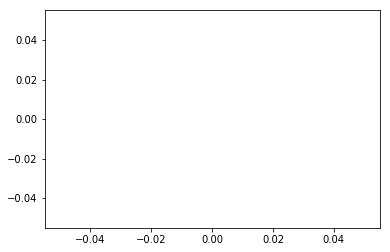

In [30]:
fig,ax = plt.subplots()
for met in means.keys():
    plotvals = means[met]
    if maxODs[met] > 0.3:
        alpha = 0.9
    else:
        alpha = 0.01
    ax.plot(plotvals.index.values,plotvals.values,alpha=alpha,label = met)

In [11]:
# threshold the growth data to get positive growth conditions only
growth_threshold = 0.3
positive_growth_conditions = {condition:maxODs[condition] for condition in maxODs.keys() if maxODs[condition] > growth_threshold}
phenotypes = pd.DataFrame.from_dict(positive_growth_conditions,orient='index')
phenotypes.columns = ["Max OD"]

# Read in the bioog:seed file and merge with the positive growth data to get SEED compound ids for each metabolite
biolog_to_seed = pd.read_csv('../data/biolog_names_to_seed.tsv', sep = '\t')
biolog_to_seed.index = biolog_to_seed["name"]
biolog_to_seed = biolog_to_seed.drop("name", axis=1)
carbon_sources = phenotypes.index.tolist()
phenotypes = phenotypes.merge(biolog_to_seed, left_index=True, right_index=True)
carbon_sources_post_merge = phenotypes.index.tolist()
# Print out the metabolites missing identifiers. These might be expected (e.g. pectin is a polymer that
# cannot be properly represented, so we don't include it)
print("The following compounds are missing; is this expected?", set(carbon_sources) - set(carbon_sources_post_merge))

ValueError: Length mismatch: Expected axis has 0 elements, new values have 1 elements

In [12]:
phenotypes

""


In [6]:
import medusa

# Load the biolog data from Plata et al., Nature 2014
from medusa.test import load_biolog_plata
biolog_base_composition, biolog_base_dict, biolog_thresholded = load_biolog_plata()
biolog_base_composition

,Name,ID
0,H2O,cpd00001_e
1,O2,cpd00007_e
2,Phosphate,cpd00009_e
3,CO2,cpd00011_e
4,NH3,cpd00013_e
5,Mn2+,cpd00030_e
6,Zn2+,cpd00034_e
7,Sulfate,cpd00048_e
8,Cu2+,cpd00058_e
9,Ca2+,cpd00063_e


In [7]:
# load the universal reaction database
from medusa.test import load_universal_modelseed
from cobra.core import Reaction
import cobra

# load the modelseed universal model. This will take a few minutes.
universal = load_universal_modelseed()

# load the psuedomonas syringae draft recon
seed_draft = cobra.io.load_json_model('../data/modelseed_data/modelseed_draft_psy_DC3000.json')

# add all reactions from the draft to the universal if they are not already present
add_to_universal = []
for rxn in seed_draft.reactions:
    if rxn.id != 'bio1':
        if rxn.id not in [r.id for r in universal.reactions]:
            add_to_universal.append(rxn.copy())

universal.add_reactions(add_to_universal)


# commented section below is not relevant if adding the draft, gapfilled pseudomonas syringae recon
# to the universal

# # Add the ACP pantetheine reaction that seems to be essential in many reconstructions
# # but is missing from our universal reaction database.

# h2o = universal.metabolites.get_by_id("cpd00001_c")
# acp = universal.metabolites.get_by_id("cpd11493_c")
# hplus = universal.metabolites.get_by_id("cpd00067_c")
# pppant = universal.metabolites.get_by_id("cpd00834_c")
# apo_acp = universal.metabolites.get_by_id("cpd12370_c")

# acp_ppp = Reaction("rxn06022_c")
# acp_ppp.name = "[Acyl-carrier-protein] 4'-pantetheine-phosphohydrolase"
# reaction.


In [8]:
# Load the psy draft model
model = cobra.io.read_sbml_model('../results/reconstructions/model_post_ensemble_curation_round1.xml')

# remove the old biomass reactions
#model.remove_reactions(['PAO1_Biomass','PA_Biomass_v13ub','PA_Biomass_v13','temp_biomass'])

# remove all exchange reactions for convenience
#model.remove_reactions([rxn.id for rxn in model.reactions if rxn.id.startswith('EX_')])

# remove troublesome components from the biomass function, such as polymers.
#bm_rxn = model.reactions.get_by_id('PA_Biomass_v4')


In [9]:
# Swap out the biomass function for the one from the draft
#model.remove_reactions(['PA_Biomass_v4'])
model.add_reaction(seed_draft.reactions.get_by_id('bio1').copy())
model.objective = 'bio1'
#model.objective = 'temp_biomass'

In [10]:
# remove troublesome components from the biomass function, such as polymers.
# bm_rxn = model.reactions.get_by_id('PA_Biomass_v4')
# for met in bm_rxn.metabolites:
#     print(met.id,met.name)
    
# peptido_poly = model.metabolites.get_by_id('cpd15665_c')
# pseudomonas_lipidA = model.metabolites.get_by_id('cpd17066_c')
# ppeth_dien = model.metabolites.get_by_id("cpd15532_c")

# bm_rxn.subtract_metabolites({peptido_poly : bm_rxn.get_coefficient(peptido_poly.id),
#                              pseudomonas_lipidA : bm_rxn.get_coefficient(pseudomonas_lipidA),
#                             ppeth_dien : bm_rxn.get_coefficient(ppeth_dien)})
# bm_rxn.metabolites
# TODO: balance biomass function coefficients

In [11]:
# check for biolog base components in the model and record
# the metabolites/exchanges that need to be added
add_mets = []
add_exchanges = []
for met in list(biolog_base_dict.keys()):
    try:
        model.metabolites.get_by_id(met)
    except:
        print('no '+met)
        add_met = universal.metabolites.get_by_id(met).copy()
        add_mets.append(add_met)

for met in list(biolog_base_dict.keys()):
    # Search for exchange reactions
    try:
        model.reactions.get_by_id('EX_'+met)
    except:
        add_met = universal.metabolites.get_by_id(met)
        ex_rxn = Reaction('EX_' + met)
        ex_rxn.name = "Exchange reaction for " + met
        ex_rxn.lower_bound = -1000
        ex_rxn.upper_bound = 1000
        ex_rxn.add_metabolites({add_met:-1})
        add_exchanges.append(ex_rxn)
        if add_met.id not in [m.id for m in add_mets]:
            add_mets.append(add_met)

no cpd00007_e
no cpd00099_e
no cpd00028_e
no cpd00030_e
no cpd00063_e
no cpd00011_e
no cpd00268_e
no cpd00254_e
no cpd10515_e


In [12]:
# Find metabolites from the biolog data that are missing in the test model
# and add them from the universal
missing_mets = []
missing_exchanges = []
media_dicts = {}

# remove duplicate conditions by using a set
for met_id in set(phenotypes['seed_id'].tolist()):
    media_dict = biolog_base_dict.copy()
    
    for single_met_id in met_id.split(','):
        # make a boolean indicator for metabolites missing from both
        # the model and the universal model
        missing = False
        
        # add the _e suffix for extracellular metabolites
        single_met_id = single_met_id + '_e'
        
        # search for the metabolite in the model.
        # If missing, try to find it in the universal.
        if single_met_id in [m.id for m in model.metabolites]:
            met = model.metabolites.get_by_id(single_met_id)
        else:
            if single_met_id in [m.id for m in universal.metabolites]:
                met = universal.metabolites.get_by_id(single_met_id)
            else:
                print(single_met_id + ' not in universal. Ignoring metabolite.')
                missing = True
        
        # If the metabolite was in the universal or the model,
        # check for an existing exchange reaction. If not there,
        # create and add the exchange reaction.
        if not missing:
            if 'EX_' + single_met_id not in [rxn.id for rxn in model.reactions]:
                ex_rxn = Reaction('EX_' + single_met_id)
                ex_rxn.name = "Exchange reaction for " + single_met_id
                ex_rxn.lower_bound = -1000
                ex_rxn.upper_bound = 1000
                ex_rxn.add_metabolites({met:-1})
                if ex_rxn.id not in [r.id for r in missing_exchanges]:
                    missing_exchanges.append(ex_rxn)
            if met_id in media_dicts.keys():
                # if media dict was already there, it means this is a double C/N
                # case (E.g. D+L mets). Don't need to alter the rest of the dict.
                media_dict['EX_'+single_met_id] = 1000
            else:
                media_dict = {'EX_'+k:v for k,v in media_dict.items()}
                media_dict['EX_'+single_met_id] = 1000
            
            media_dicts[met_id] = media_dict
            print(met_id + ' was not missing')
        
#         try:
#             met = model.metabolites.get_by_id(single_met_id)
            
#         except:
#             try:
#                 met = universal.metabolites.get_by_id(single_met_id).copy()
                
#             except:
#                 print(single_met_id + ' not in universal. Ignoring metabolite.')
#                 break
#             print(single_met_id + " was not in model, adding met and exchange reaction")
#             if met.id not in [m.id for m in missing_mets]:
#                 missing_mets.append(met)
            
# #             ex_rxn = Reaction('EX_' + single_met_id)
# #             ex_rxn.name = "Exchange reaction for " + single_met_id
# #             ex_rxn.lower_bound = -1000
# #             ex_rxn.upper_bound = 1000
# #             ex_rxn.add_metabolites({met:-1})
# #             missing_exchanges.append(ex_rxn)
#         # Double check for exchange reactions. In modelSEED models built
#         # using the standard pipeline, this will never be necessary because
#         # any extracellular metabolite in the model will have an exchange reaction.
#         # However, for custom reconstructions, users may not have added an exchange reaction
#         # for each extracellular metabolite, hence this check.
#         if 'EX_' + single_met_id not in [rxn.id for rxn in model.reactions]:
#             ex_rxn = Reaction('EX_' + single_met_id)
#             ex_rxn.name = "Exchange reaction for " + single_met_id
#             ex_rxn.lower_bound = -1000
#             ex_rxn.upper_bound = 1000
#             ex_rxn.add_metabolites({met:-1})
#             if ex_rxn.id not in [r.id for r in missing_exchanges]:
#                 missing_exchanges.append(ex_rxn)
        
#         media_dicts[met_id] = {'EX_'+k:v for k,v in media_dicts[met_id].items()}
#         media_dicts[met_id]['EX_'+single_met_id] = 1000
    


cpd00105 was not missing
cpd00119 was not missing
cpd02143_e not in universal. Ignoring metabolite.
cpd00041 was not missing
cpd00129 was not missing
cpd00432 was not missing
cpd00652 was not missing
cpd00020 was not missing
cpd11585 was not missing
cpd00053 was not missing
cpd00314 was not missing
cpd00117 was not missing
cpd00107 was not missing
cpd00054 was not missing
cpd00222 was not missing
cpd00248 was not missing
cpd00121 was not missing
cpd00281 was not missing
cpd00132 was not missing
cpd00035 was not missing
cpd00477 was not missing
cpd00666 was not missing
cpd00036 was not missing
cpd00164 was not missing
cpd00130 was not missing
cpd00249 was not missing
cpd00246 was not missing
cpd00106 was not missing
cpd00051 was not missing
cpd00023 was not missing
cpd00386 was not missing
cpd00100 was not missing
cpd11602 was not missing
cpd00137 was not missing
cpd00027 was not missing
cpd00076 was not missing
cpd00138 was not missing
cpd01307 was not missing
cpd00082 was not missing


In [13]:
# Add the exchange reactions for metabolites from biolog base
model.add_metabolites(add_mets)
model.add_reactions(add_exchanges)

# Do the same for single C/N supplements
model.add_metabolites(missing_mets)
model.add_reactions(missing_exchanges)

In [14]:
# # for debugging, let's add exchange reactions for all metabolites to the model.
# # This will ensure that a solution exists that enables biomass in any condition.
# [m.id for m in universal.reactions if m.id.startswith('EX_')]

# extracellular_mets = [m.id for m in universal.metabolites if m.id.endswith('_e')]
# ex_rxns = []
# for met in extracellular_mets:
#     ex_rxn = Reaction('EX_' + met)
#     ex_rxn.name = "Exchange reaction for " + met
#     ex_rxn.lower_bound = 0
#     ex_rxn.upper_bound = 1000
#     ex_rxn.add_metabolites({universal.metabolites.get_by_id(met):-1})
#     ex_rxns.append(ex_rxn)
# model.add_reactions(ex_rxns)

In [15]:
from medusa.reconstruct.expand import iterative_gapfill_from_binary_phenotypes

In [16]:
## debugging only: gapfill on complete media prior to biolog

# # select a subset of the biolog conditions to perform gapfilling with

# model.objective = 'PA_Biomass_v4'

# temp_media_dict = {'complete':model.medium}

# # complete media biomass feasibility check
# num_cycles = 1
# lower_bound = 0.05
# flux_cutoff = 1E-11
# ensemble = iterative_gapfill_from_binary_phenotypes(model,universal,temp_media_dict,num_cycles,\
#                                  lower_bound=lower_bound,\
#                                  inclusion_threshold=flux_cutoff,\
#                                  exchange_reactions=False,\
#                                  demand_reactions=False,\
#                                  exchange_prefix='EX')


In [17]:
## for debugging only: gapfill for demand reactions


# temp_media_dict = {'complete':model.medium}
# # demand reaction check for individual biomass precursors
# for metabolite in model.reactions.get_by_id('PA_Biomass_v4').reactants:
#     dm_rxn = Reaction(metabolite.id+'_DM')
#     dm_rxn.lower_bound = 0
#     dm_rxn.upper_bound = 1000
#     dm_rxn.add_metabolites({metabolite:-1})
#     model.add_reactions([dm_rxn])
#     model.objective = dm_rxn

#     print("gapfilling for " + metabolite.id)
#     num_cycles = 1
#     lower_bound = 0.05
#     flux_cutoff = 1E-10
#     ensemble = iterative_gapfill_from_binary_phenotypes(model,universal,temp_media_dict,num_cycles,\
#                                      lower_bound=lower_bound,\
#                                      inclusion_threshold=1E-10,\
#                                      exchange_reactions=False,\
#                                      demand_reactions=False,\
#                                      exchange_prefix='EX')
    
#     model.remove_reactions([dm_rxn])

In [18]:
# gapfill for actual biolog data.
num_cycles = 500
lower_bound = 0.05
flux_cutoff = 1E-12
ensemble = iterative_gapfill_from_binary_phenotypes(model,universal,media_dicts,num_cycles,\
                                     lower_bound=lower_bound,\
                                     inclusion_threshold=flux_cutoff,\
                                     exchange_reactions=False,\
                                     demand_reactions=False,\
                                     exchange_prefix='EX')

Constraining lower bound for bio1
starting cycle number 0
starting cycle number 1
starting cycle number 2
starting cycle number 3
starting cycle number 4
starting cycle number 5
starting cycle number 6
starting cycle number 7
starting cycle number 8
starting cycle number 9
starting cycle number 10
starting cycle number 11
starting cycle number 12
starting cycle number 13
starting cycle number 14
starting cycle number 15
starting cycle number 16
starting cycle number 17
starting cycle number 18
starting cycle number 19
starting cycle number 20
starting cycle number 21
starting cycle number 22
starting cycle number 23
starting cycle number 24
starting cycle number 25
starting cycle number 26
starting cycle number 27
starting cycle number 28
starting cycle number 29
starting cycle number 30
starting cycle number 31
starting cycle number 32
starting cycle number 33
starting cycle number 34
starting cycle number 35
starting cycle number 36
starting cycle number 37
starting cycle number 38
s

In [19]:
# save the ensemble
save_dir = ("../results/ensembles/psy_ensemble_500_SEED_biomass_round2.pickle")
ensemble.to_pickle(save_dir)